# Sentinel-2 Methane Retrieval - Legacy Test Cases
A theoretical and practical review of techniques recently developed to identify and quantify methane plumes / emission sources using Top of Atmosphere shortwave infrared reflectance measurements acquired by the Sentinel-2 MSI sensor.

In [1]:
import os
import yaml
import geopandas as gpd

from munch import munchify

In [2]:
import ee
import geemap

In [3]:
#ee.Authenticate()
ee.Initialize()

In [4]:
# import functions
%run functions.ipynb

In [5]:
# parse workflow into dict
with open( os.path.join( get_root_path(), 's2/cfg/s2-demo.yml' ), 'r', encoding='UTF-8' ) as config:
    config = munchify( yaml.safe_load( config ) )

# Introduction

Methane is a potent greenhouse gas that is responsible for roughly one quarter of the climate warming experienced since preindustrial times (IPCC, 2013). Half of the world’s methane emissions originate from a myriad of anthropogenic sources including livestock farming, coal mining, oil and gas production, and waste management. 

Studies have shown, that between 60-90% of methane leaked from anthropogenic sources originate from a relatively small fraction of super emitter events (~5%), each producing flux (𝑄) in excess of 100 kg hr-1 (Duren et al., 2019). 

Super-emitter events are large leaks from methane point sources either from maintenance operations at oil rigs, pipelines, or well pads or caused by accidents, malfunctioning equipment, or abnormal operating conditions. 

Given methane’s short atmospheric lifetime, fixing methane super-emitter leaks is a cost-effective and practical means of climate change mitigation. Reduction by as much as 45% is possible within a decade using cost-effective, existing technologies. 

Methane super emission events are typically underestimated - Alvarez et al. (2018) reported that O & G supply chain emissions in 2015 were likely 60% higher than the United States Environmental Protection Agency inventory estimate. Earth Observation technologies provide a framework for rapidly identifying super-emitter events and routinely monitoring emissions from methane point sources. Due to ever-increasing data volumes, an automated methane detection system would greatly assist evidence-informed policy making and enforcement by national government and environmental agencies. 

# Methane Detection

Methane exhibits unique spectral characteristics in the shortwave-infrared (SWIR) portion of the electromagnetic spectrum where there is a weak (∼1700 nm) and strong (∼2300 nm) absorption window. Spaceborne measurements of solar radiation reflected by the Earth’s surface at these wavelengths are typically correlated to CH4 concentration enhancements from point source emissions - see HITRAN derived transmittance spectra of atmospheric CH4 shown in red below.

<img src="spectra.png"/>

<p style="text-align: center;">Figure 1: HITRAN derived transmittance spectra of atmospheric H2O (green), CO2 (blue), and CH4 (red) resampled to 2 nm</p>

## Hyperspectral Remote Sensing

Standard retrieval algorithms estimate vertical column concentrations (mol m−2) of atmospheric methane by fitting a radiative transfer model to top of the atmosphere reflectances captured at SWIR frequencies. In the case of hyperspectral remote sensing, measurements are highly resolved, with full width at half maximum of 0.1 to 10 nm - often tens to thousands of measurements captured at regular intervals across the SWIR spectrum. 

Hyperspectral satellite instruments with 5–10 nm spectral resolution and high spatial resolution (~30 m) like PRISMA / AHSI have the capacity to resolve the source of methane plumes under favorable observational conditions - the GHGSat satellites are specifically designed for methane point-source detection. However, the CH4 monitoring capabilities of these satellites are limited by their spatial coverage, revisit times and tasking requirements - GHGSat satellites have a limited observation area of 12 km × 12 km (Jervis et al., 2021).

ESA Sentinel-5p TROPOMI measures column-averaged methane with high precision and daily global coverage (Lorente et al., 2022; Veefkind et al., 2012).  Sentinel-5p regularly detects large methane plumes across the globe (Pandey et al., 2019, Varon et al., 2019) however it generally cannot pinpoint the sources of these plumes due to its relatively
coarse spatial resolution of 5.5 km × 7 km. 

## Multispectral Remote Sensing

Multispectral satellites such as Sentinel-2 and Landsat acquire high spatial resolution imagery with rapid revisit times: global coverage in <5 days for Sentinel-2 and < 3 days for the combination of Sentinel-2, Landsat-8, and Landsat-9 (Li and Chen, 2020). 

Despite their very low spectral resolution in short wave infrared (SWIR) bands (100–200 nm), it is nevertheless possible to retrieve methane plumes in close vicinity of massive point sources using a combination of SWIR observations at 1600 nm and 2200 nm - sufficiently close to have similar surface and aerosol reflectance properties but differ in their methane absorption properties.

Figure 2 shows the spectral bandwidths of Sentinel-2 bands 11 and 12 along with methane, CO2, and water vapor optical depths in the 1500–2500 nm SWIR spectral range, based on absorption line spectra from the HIgh-resolution TRANsmission molecular absorption (HITRAN2016) database (Gordon et al., 2017). Band 11 extends over a set of weak methane absorption lines near 1650 nm. Band 12 includes stronger absorption lines over the 2200–2300 nm range. The mean methane optical depth in band 12 is 5 times larger than that in band 11.

<img src="s2-spectra.png"/>

<p style="text-align: center;">Figure 2: Slant column optical depths of Methane (CH4), CO2, and water vapor (H2O) in the 1500–2500nm SWIR spectral range, based on absorption line strengths from the HITRAN2016 database sampled at 20pm spectral resolution for a solar zenith angle of 40° and satellite viewing angle of 0°</p>

Absorption by water vapor and CO2 in the two bands introduces a risk of methane retrieval artifacts because the coarse MSI spectral resolution does not allow separation of species. However, water vapor and CO2 are generally not co-emitted with methane from large point sources, so their concentrations can be assumed uniform across a given scene

__Note__: The MSIs aboard Sentinel-2A and Sentinel-2B have slightly different spectral transmission window positions and widths - gray shaded areas in Figure 2 indicate the spectral ranges of bands 11 and 12 for Sentinel-2A (solid) and Sentinel-2B (hatched).

# Sentinel-2 Methane Retrieval

The primary objective of this preliminary study was the development of an prototype workflow to quantify methane column enhancements derived from Sentinel-2 level 1C (L1C) top-of-atmosphere SWIR reflectances utilising the retrieval algorithms described in Varon et. al. (2021).

## Single-band–multi-pass (SBMP) retrieval algorithm

The SBMP retrieval method compares band-12 TOA reflectances R12 measured over an active methane point source with values  measured over the same location on a day without emissions. The fractional variation in radiance can be expressed as follows:
<img src="sbmp.png" width="200"/>

where 𝑐 is the proportional coefficient of the radiance changes at the same location on different days. Such changes could be due to variable observation zenith angles, atmospheric conditions, or surface conditions. The proportional coefficient is estimated by the least squares fitting of the radiances of R12 (with methane emissions) and the R′12 (without methane emissions) in the target area. Methane column concentration enhancement (ΔΩ) is derived by comparing ΔRSBMP to a fractional absorption model:

<img src="sbmp_omega.png" width="300"/>

where T12(Ω) is the simulated TOA spectral radiance for the nominal methane column concentration Ω (mol m−2), integrated over the band-12 spectral range and including absorption by CO2 and H2O. 

The SBMP retrieval has the benefit of conceptual simplicity but the disadvantage of requiring measurements from more than one satellite pass. It may be challenging to identify a plume-free satellite pass when monitoring persistent methane sources. Furthermore, the retrieval is vulnerable to non-uniform changes in surface albedo over time. 

## Multi-band–single-pass (MBSP) retrieval algorithm

The MBSP retrieval method utilizes the albedo difference between band-11 and band-12 in the single satellite pass for methane concentration enhancement measurements with an albedo change of:

<img src="assets/mbsp.png" width="200"/>

where 𝑐 is determined by least-squares fitting of R12 against R11 albedo across the scene. For the MBSP retrieval method, the fractional change in reflectance is given by:

<img src="assets/mbsp_omega.png" width="300"/>

This approach relies on surface reflectance similarities between the two adjacent bands. The empirical scaling factor c now accounts for uncalibrated differences in signal throughput between bands 11 and 12, plus spectral dependences of surface albedo assumed to be uniform across the scene. The fractional absorption model accounts for the non-zero methane sensitivity of band 11 by subtracting its simulated fractional absorption from that of band 12. 

The MBSP retrieval has the advantage of requiring just one satellite pass to retrieve methane concentrations, but the disadvantage of using signals acquired from different spectral bands with central wavelengths separated by 600 nm.

## Multi-band–multi-pass (MBMP) retrieval algorithm

The MBMP combines the techniques of the MBSP and SBMP algorithms, deriving methane column enhancements from the difference between MBSP retrievals acquired via different satellite passes. In this method, systematic errors in the MBSP retrieval ΔΩMBSP due to wavelength separation between bands are corrected by subtracting another MBSP retrieval performed for a satellite pass when no methane plume was present:
<img src="mbmp.png" width="250"/>
If the systematic errors in the MBSP retrievals are similar on both passes, then this subtraction removes artifacts present in the retrieval field, leaving only true methane enhancements.

# Demonstration

## Algeria

In-house implementation of the Varon et. al.(2021) CH4 retrieval methods was initially evaluated against Sentinel-2 L1C SWIR imagery acquired of super-emission event at a well pad in the Algerian Hassi Messaoud oil field on 20 November 2019. This source was detected in 93 % of cloud-free scenes, with source rates ranging from 2.6 to 51.9 t h−1 (averaging 9.3 t h−1) until it was shut down by a flare lit in August 2020. 

In [6]:
# get scenario and aoi
scenario = get_scenario( config, 'Hassi_Messaoud' )
aoi = get_aoi( scenario )

In [7]:
# get cloud-free scene collocated with emission event 
event = get_best_scene( aoi, 
                        get_date_offset( scenario.event_date ), 
                        get_date_offset( scenario.event_date, 1 ) 
)

# get cloud-free scene collocated with reference
reference = get_best_scene( aoi, 
                            get_date_offset( scenario.reference_date ), 
                            get_date_offset( scenario.reference_date, 1 ),
                            target_red=event[ 'data' ][ 'red' ],
                            min_red_r2=0.85
)

Searching: 2019-11-20 -> 2019-11-21
Found 2 scenes ...
... scene 1 of 2: 20191120T101321_20191120T101408_T32SKA
...... masked pixels = 0.0%
...... OK!
Searching: 2019-10-06 -> 2019-10-07
Found 2 scenes ...
... scene 1 of 2: 20191006T101029_20191006T101850_T32SKA
...... masked pixels = 0.0%
...... red r2 = 0.8504233144848576
...... OK!


slope= 1.1538465138088916
y-intercept= 2.2630326283637417e-06
slope= 1.1405932646700958
y-intercept= 1.3937722423309739e-06


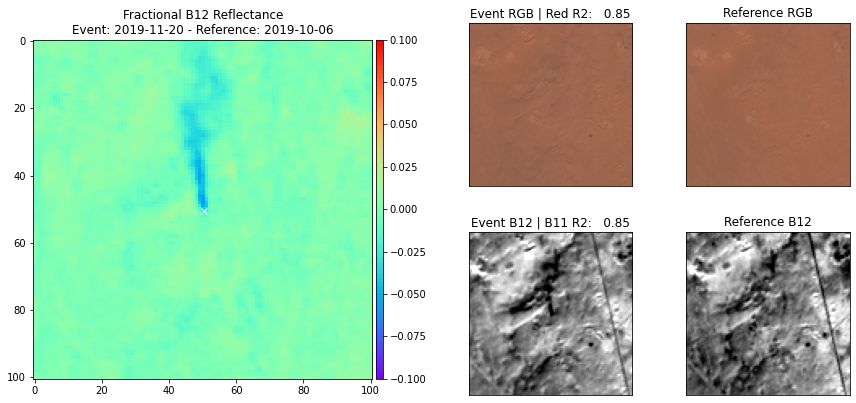

In [8]:
# get delta B12 reflectance using multiband multipass method
delR = get_mbmp( event, reference )
plot_output( event, reference, delR, title='Fractional B12 Reflectance\n', vrange=( -0.1, 0.1 ) )

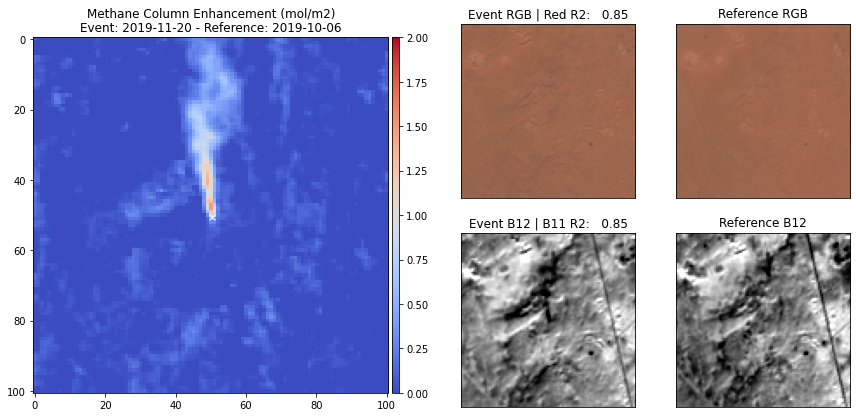

In [9]:
# convert fractional reflectance to column enhancement
omega = convert_delR_to_omega( delR, 
                               event[ 'info' ]['MEAN_SOLAR_ZENITH_ANGLE'], 
                               event[ 'info' ]['MEAN_INCIDENCE_ZENITH_ANGLE_B12'] 
)
plot_output( event, reference, omega, title='Methane Column Enhancement (mol/m2)\n', cmap='coolwarm', vrange=( 0.0, 2.0 ) )

## Turkmenistan

To demonstrate the capabilities of the GHGSat-D demonstration satellite instrument, Varon et al. (2019) focussed on monitoring methane emissions from a compressor station in the Korpezhe oil and gas field of Turkmenistan (August 2015 to November 2020, observed every 5 d). This source was detected in 40 % of cloud-free scenes, with variable intermittency and a 9-month shutdown period in March–December 2019 before it resumed; source rates ranged from 3.5 to 92.9 t h−1 (averaging 20.5 t h−1).

In [10]:
# get scenario and aoi
scenario = get_scenario( config, 'Korpezhe_2' )
aoi = get_aoi( scenario )

In [11]:
# get cloud-free scene collocated with emission event 
event = get_best_scene( aoi, 
                        get_date_offset( scenario.event_date ), 
                        get_date_offset( scenario.event_date, 1 ) 
)

# get cloud-free scene collocated with reference
reference = get_best_scene( aoi, 
                            get_date_offset( scenario.reference_date ), 
                            get_date_offset( scenario.reference_date, 1 ),
                            target_red=event[ 'data' ][ 'red' ],
                            min_red_r2=0.75
)

Searching: 2018-06-29 -> 2018-06-30
Found 2 scenes ...
... scene 1 of 2: 20180629T070619_20180629T071300_T39SYC
...... masked pixels = 0.0%
...... OK!
Searching: 2018-05-20 -> 2018-05-21
Found 2 scenes ...
... scene 1 of 2: 20180520T070619_20180520T071010_T39SYC
...... masked pixels = 0.0%
...... red r2 = 0.770704652275104
...... OK!


slope= 1.0871418117442384
y-intercept= 1.100314135177499e-06
slope= 1.0480071083178935
y-intercept= 1.387847525254127e-06


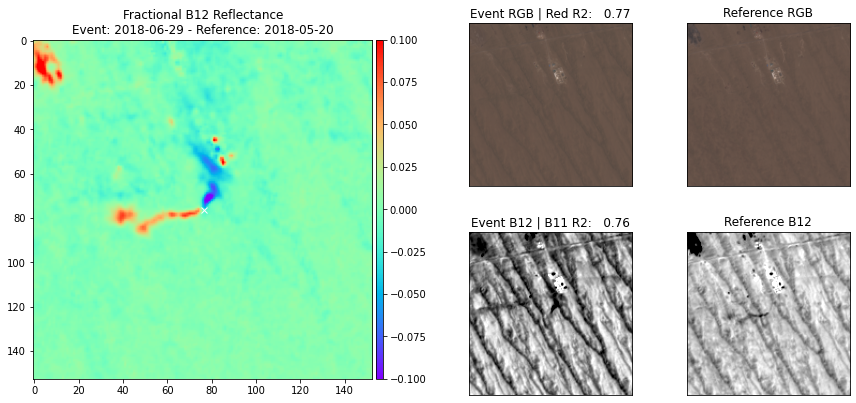

In [12]:
# get delta B12 reflectance using multiband multipass method
delR = get_mbmp( event, reference )
plot_output( event, reference, delR, title='Fractional B12 Reflectance\n', vrange=( -0.1, 0.1 ) )

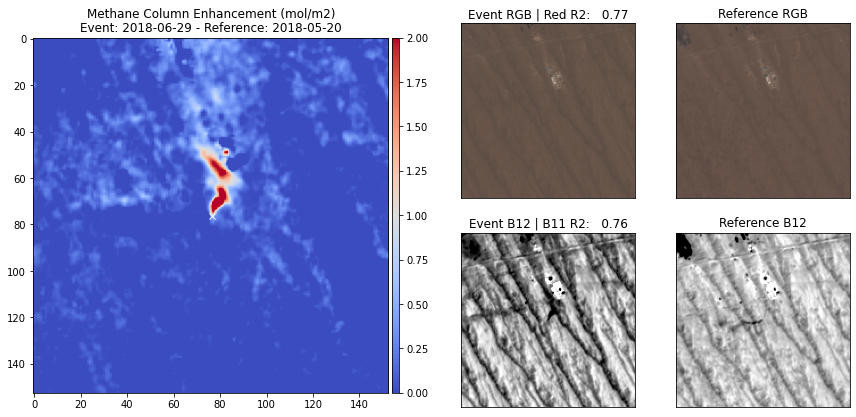

In [13]:
# convert fractional reflectance to column enhancement
omega = convert_delR_to_omega( delR, 
                               event[ 'info' ]['MEAN_SOLAR_ZENITH_ANGLE'], 
                               event[ 'info' ]['MEAN_INCIDENCE_ZENITH_ANGLE_B12'],
)
plot_output( event, reference, omega, title='Methane Column Enhancement (mol/m2)\n', cmap='coolwarm', vrange=( 0.0, 2.0 ) )

## Permian Basin

In [14]:
# get scenario and aoi
scenario = get_scenario( config, 'Permian_Basin_1' )
aoi = get_aoi( scenario )

In [15]:
# get cloud-free scene collocated with emission event 
event = get_best_scene( aoi, 
                        get_date_offset( scenario.event_date ), 
                        get_date_offset( scenario.event_date, 1 ) 
)

# get cloud-free scene collocated with reference
reference = get_best_scene( aoi, 
                            get_date_offset( scenario.reference_date ), 
                            get_date_offset( scenario.reference_date, 30 ),
                            target_red=event[ 'data' ][ 'red' ]
)

Searching: 2020-07-11 -> 2020-07-12
Found 2 scenes ...
... scene 1 of 2: 20200711T171859_20200711T172336_T14SKA
...... masked pixels = 0.0%
...... OK!
Searching: 2020-05-01 -> 2020-05-31
Found 18 scenes ...
... scene 1 of 18: 20200502T171849_20200502T173457_T14SKA
...... masked pixels = 0.0%
...... red r2 = 0.9730360617703907
...... OK!


slope= 1.3147589771197514
y-intercept= 7.049600202803575e-05
slope= 1.2832206704340852
y-intercept= 9.309340149281608e-05


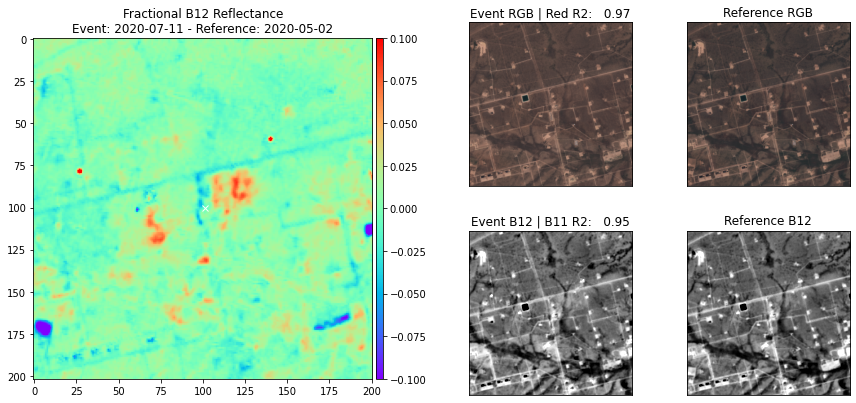

In [16]:
# get delta B12 reflectance using multiband multipass method
delR = get_mbmp( event, reference )
plot_output( event, reference, delR, title='Fractional B12 Reflectance\n', vrange=( -0.1, 0.1 ) )

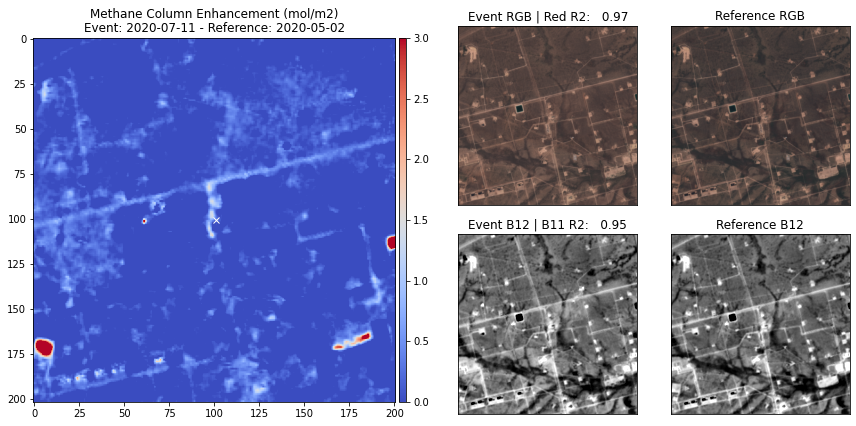

In [17]:
# convert fractional reflectance to column enhancement
omega = convert_delR_to_omega( delR, 
                               event[ 'info' ]['MEAN_SOLAR_ZENITH_ANGLE'], 
                               event[ 'info' ]['MEAN_INCIDENCE_ZENITH_ANGLE_B12'] 
)
plot_output( event, reference, omega, title='Methane Column Enhancement (mol/m2)\n', cmap='coolwarm', vrange=(0.0, 3.0) )

In [18]:
# get scenario and aoi
scenario = get_scenario( config, 'Permian_Basin_2' )
aoi = get_aoi( scenario )

In [19]:
# get cloud-free scene collocated with emission event 
event = get_best_scene( aoi, 
                        get_date_offset( scenario.event_date ), 
                        get_date_offset( scenario.event_date, 1 ) 
)

# get cloud-free scene collocated with reference
reference = get_best_scene( aoi, 
                            get_date_offset( scenario.reference_date ), 
                            get_date_offset( scenario.reference_date, 30 ),
                            target_red=event[ 'data' ][ 'red' ]
)

Searching: 2020-07-16 -> 2020-07-17
Found 2 scenes ...
... scene 1 of 2: 20200716T171901_20200716T173445_T14SKA
...... masked pixels = 0.0%
...... OK!
Searching: 2020-05-01 -> 2020-05-31
Found 18 scenes ...
... scene 1 of 18: 20200502T171849_20200502T173457_T14SKA
...... masked pixels = 0.0%
...... red r2 = 0.9582616116326248
...... OK!


slope= 1.3378633076948492
y-intercept= 7.032392396212256e-05
slope= 1.2832206704340852
y-intercept= 9.309340149281608e-05


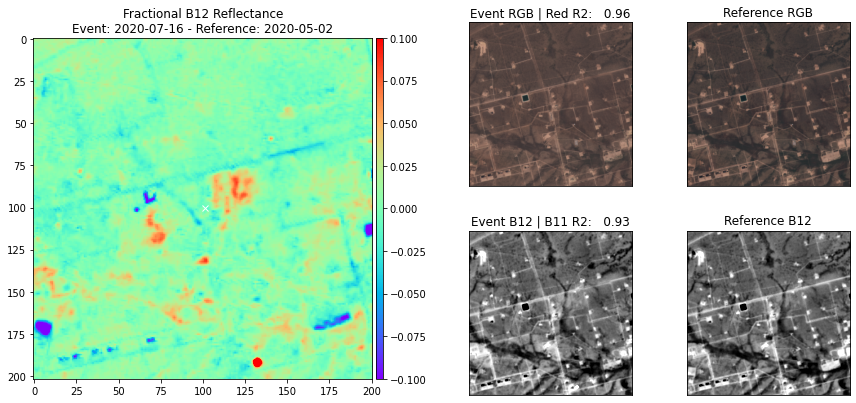

In [20]:
# get delta B12 reflectance using multiband multipass method
delR = get_mbmp( event, reference )
plot_output( event, reference, delR, title='Fractional B12 Reflectance\n', vrange=( -0.1, 0.1 ) )

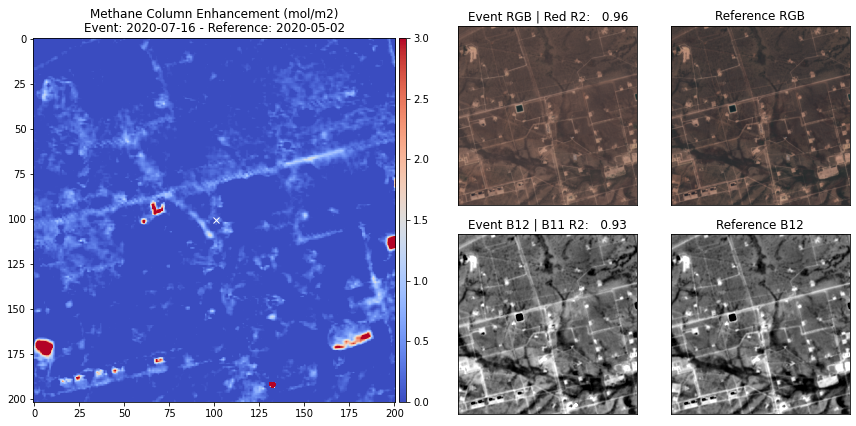

In [21]:
# convert fractional reflectance to column enhancement
omega = convert_delR_to_omega( delR, 
                               event[ 'info' ]['MEAN_SOLAR_ZENITH_ANGLE'], 
                               event[ 'info' ]['MEAN_INCIDENCE_ZENITH_ANGLE_B12'] 
)
plot_output( event, reference, omega, title='Methane Column Enhancement (mol/m2)\n', cmap='coolwarm', vrange=(0.0, 3.0) )

In [22]:
# get cloud-free scene collocated with emission event 
event = get_best_scene( aoi, 
                        get_date_offset( scenario.event_date, 180 ), 
                        get_date_offset( scenario.event_date, 190 ) 
)

# get cloud-free scene collocated with reference
reference = get_best_scene( aoi, 
                            get_date_offset( scenario.reference_date, 180 ), 
                            get_date_offset( scenario.reference_date, 190 ),
                            target_red=event[ 'data' ][ 'red' ]
)

Searching: 2021-01-12 -> 2021-01-22
Found 6 scenes ...
... scene 1 of 6: 20210112T172701_20210112T173120_T14SKA
...... masked pixels = 100.0%
... scene 2 of 6: 20210112T172701_20210112T173120_T13SGR
...... masked pixels = 100.0%
... scene 3 of 6: 20210115T173701_20210115T174105_T14SKA
...... masked pixels = 0.0%
...... OK!
Searching: 2020-10-28 -> 2020-11-07
Found 8 scenes ...
... scene 1 of 8: 20201029T172439_20201029T173458_T14SKA
...... masked pixels = 0.0%
...... red r2 = 0.8686714239725289
... scene 2 of 8: 20201029T172439_20201029T173458_T13SGR
...... masked pixels = 0.0%
...... red r2 = 0.385807343621591
... scene 3 of 8: 20201101T173459_20201101T174107_T14SKA
...... masked pixels = 0.0%
...... red r2 = 0.8643537988390174
... scene 4 of 8: 20201101T173459_20201101T174107_T13SGR
...... masked pixels = 0.0%
...... red r2 = 0.38533552242671754
... scene 5 of 8: 20201103T172511_20201103T173504_T14SKA
...... masked pixels = 0.0%
...... red r2 = 0.9334666230037428
... scene 6 of 8: 20

slope= 1.2159534327283792
y-intercept= 1.3044010766537524e-05
slope= 1.2635843583676414
y-intercept= 4.1458169185495076e-05


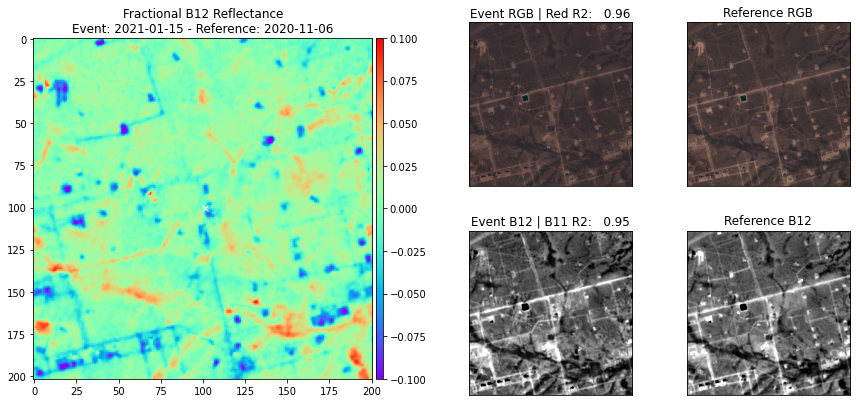

In [23]:
# get delta B12 reflectance using multiband multipass method
delR = get_mbmp( event, reference )
plot_output( event, reference, delR, title='Fractional B12 Reflectance\n', vrange=( -0.1, 0.1 ) )